# Progetto per tesi

Installazione libreria MediaPipe e download del modello da utilizzare per estrarre i keypoints dall'immagine.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!pip install -q tensorflow
!pip install -q mediapipe==0.10.0
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 35.9 MB/s eta 0:00:00


## Setup del modello di pose estimation




In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.vision.core.vision_task_running_mode import VisionTaskRunningMode
import cv2
from google.colab.patches import cv2_imshow
import os

input_folder = '/content/drive/MyDrive/Colab Notebooks/TESI/dataset/dataset_img_2'

output_folder = '/content/drive/MyDrive/Colab Notebooks/TESI/dataset/dataset_landmarks'

base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')

options = vision.PoseLandmarkerOptions(
    base_options = base_options,
    running_mode = VisionTaskRunningMode.IMAGE,
    num_poses = 1,
    min_pose_detection_confidence = 0.5,
    min_pose_presence_confidence = 0.5,
    min_tracking_confidence = 0.5,
    output_segmentation_masks = False
)

detector = vision.PoseLandmarker.create_from_options(options)

significant_indexes = [7,8,11,12,13,14,15,16,23,24,25,26,27,28,31,32]

'''
7 - left ear
8 - right ear
11 - left shoulder
12 - right shoulder
13 - left elbow
14 - right elbow
15 - left wrist
16 - right wrist
23 - left hip
24 - right hip
25 - left knee
26 - right knee
27 - left ankle
28 - right ankle
31 - left foot index
32 - right foot index
'''

'\n7 - left ear\n8 - right ear\n11 - left shoulder\n12 - right shoulder\n13 - left elbow\n14 - right elbow\n15 - left wrist\n16 - right wrist\n23 - left hip\n24 - right hip\n25 - left knee\n26 - right knee\n27 - left ankle\n28 - right ankle\n31 - left foot index\n32 - right foot index\n'

## Creazione del dataset

Estrazione e salvataggio delle coordinate corrispondenti alle pose identificate dalle immagini del dataset.

In [ ]:
''' 2d, utilizzato in una vecchia implementazione
def extract_and_save_keypoints(img_path, output_path):
  img = mp.Image.create_from_file(img_path)
  detection_result = detector.detect(img)
  pose_landmarks = detection_result.pose_landmarks[0]

  with open(output_path, 'w') as f:
    for i, pl in enumerate(pose_landmarks):
      f.write(f"{pose_landmarks[i].x},{pose_landmarks[i].y}\n")


for i, label in enumerate(os.listdir(input_folder)):
    label_folder = os.path.join(input_folder, label)
    output_label_folder = os.path.join(output_folder, str(i))

    os.makedirs(output_label_folder, exist_ok=True)

    for img_name in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_name)
        output_path = os.path.join(output_label_folder, f"{os.path.splitext(img_name)[0]}.txt")
        print(img_path, output_path)

        extract_and_save_keypoints(img_path, output_path)
'''

'''3d, TODO: prima di runnare eliminare la cartella già presente su drive
def extract_and_save_keypoints(img_path, output_path):
  img = mp.Image.create_from_file(img_path)
  detection_result = detector.detect(img)
  if(len(detection_result.pose_landmarks) > 0) :
    pose_landmarks = detection_result.pose_landmarks[0]
    with open(output_path, 'w') as f:
      for i, pl in enumerate(pose_landmarks):
        f.write(f"{pose_landmarks[i].x},{pose_landmarks[i].y},{pose_landmarks[i].z}\n")


for i, label in enumerate(os.listdir(input_folder)):
    label_folder = os.path.join(input_folder, label)
    output_label_folder = os.path.join(output_folder, str(i))

    os.makedirs(output_label_folder, exist_ok=True)

    for img_name in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_name)
        output_path = os.path.join(output_label_folder, f"{os.path.splitext(img_name)[0]}.txt")
        print(img_path, output_path)

        extract_and_save_keypoints(img_path, output_path)
'''

## Architettura di rete

Caricamento del dataset e definizione del modello

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

def load_dataset(output_folder):
    x = []
    y = []

    for label in os.listdir(output_folder):
        label_folder_landmarks = os.path.join(output_folder, label)

        for txt_name in os.listdir(label_folder_landmarks):
            landmarks_file_path = os.path.join(label_folder_landmarks, txt_name)
            with open(landmarks_file_path, 'r') as f:
                landmarks = []
                for i, line in enumerate(f):
                  if(i in significant_indexes):
                    coordinates = list(map(float, line.strip().split(',')))[:3]
                    landmarks.append(coordinates)
                landmarks = np.array(landmarks)
                landmarks = landmarks.reshape((num_keypoints, num_coordinates, 1))
                x.append(landmarks)
                y.append(int(label))

    return np.array(x), np.array(y)

num_classes = 4
num_keypoints = len(significant_indexes)
num_coordinates = 3

x, y = load_dataset(output_folder)

Leslie N. Smith, "Cyclical Learning Rates for Training Neural Networks", ha proposto l'uso di dimensioni di batch cicliche e ha dimostrato che possono essere più efficaci in alcuni casi rispetto a dimensioni di batch costanti.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def split_train_predict(x, y, seed):
  x_train, x_other, y_train, y_other = train_test_split(x, y, test_size = 0.2, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size = 0.5, random_state = seed)

  model = models.Sequential([
      layers.Conv2D(2, (3, 3), activation='relu', padding='same', input_shape=(num_keypoints, num_coordinates, 1)),
      layers.Flatten(),
      layers.Dense(num_classes, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

  model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  # model.summary()

  history = model.fit(x_train, y_train, epochs=17, validation_data=(x_val, y_val), batch_size=3)

  loss, accuracy = model.evaluate(x_test, y_test)

  print("Loss sul set di test:", loss)
  print("Accuracy sul set di test:", accuracy)

  y_pred = model.predict(x_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  f1score = f1_score(y_test, y_pred_classes, average='weighted')

  print("F1 score sul set di test", f1score)

  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss durante l\'addestramento e la validazione')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy durante l\'addestramento e la validazione')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  model.save('cnn'+str(seed)+'.h5')

  return y_test, y_pred_classes


0 14
Epoch 1/17
75/75 [==============================] - 1s 4ms/step - loss: 1.3978 - accuracy: 0.2634 - val_loss: 1.1768 - val_accuracy: 0.6071
Epoch 2/17
75/75 [==============================] - 0s 2ms/step - loss: 1.0435 - accuracy: 0.6562 - val_loss: 0.7956 - val_accuracy: 0.8571
Epoch 3/17
75/75 [==============================] - 0s 2ms/step - loss: 0.7559 - accuracy: 0.7812 - val_loss: 0.5921 - val_accuracy: 0.9286
Epoch 4/17
75/75 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.8661 - val_loss: 0.4793 - val_accuracy: 0.9286
Epoch 5/17
75/75 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.9107 - val_loss: 0.3923 - val_accuracy: 0.9286
Epoch 6/17
75/75 [==============================] - 0s 3ms/step - loss: 0.3888 - accuracy: 0.9241 - val_loss: 0.3171 - val_accuracy: 0.9286
Epoch 7/17
75/75 [==============================] - 0s 2ms/step - loss: 0.3251 - accuracy: 0.9330 - val_loss: 0.2800 - val_accuracy: 0.9643
Epoch 8/17
75/7

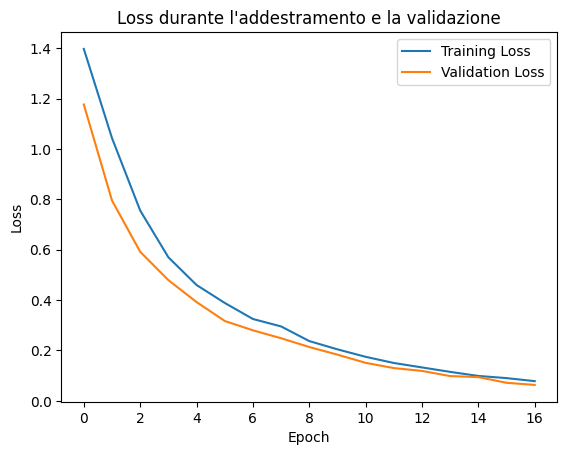

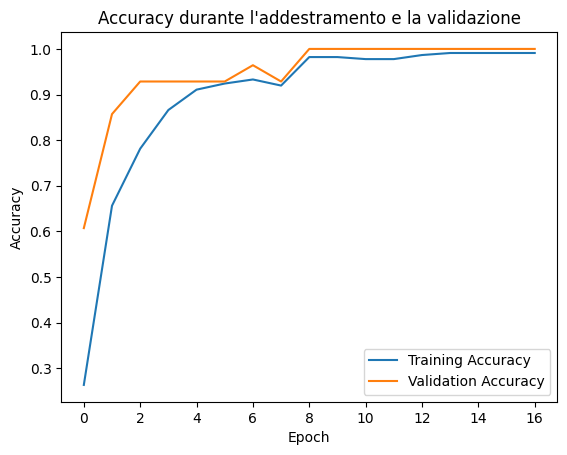

1 21
Epoch 1/17


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 1s 7ms/step - loss: 1.3338 - accuracy: 0.3438 - val_loss: 1.2832 - val_accuracy: 0.4643
Epoch 2/17
75/75 [==============================] - 0s 3ms/step - loss: 1.1953 - accuracy: 0.5134 - val_loss: 1.1408 - val_accuracy: 0.6786
Epoch 3/17
75/75 [==============================] - 0s 4ms/step - loss: 0.9735 - accuracy: 0.6830 - val_loss: 0.9149 - val_accuracy: 0.7143
Epoch 4/17
75/75 [==============================] - 0s 2ms/step - loss: 0.7418 - accuracy: 0.7991 - val_loss: 0.7064 - val_accuracy: 0.7857
Epoch 5/17
75/75 [==============================] - 0s 2ms/step - loss: 0.5573 - accuracy: 0.8482 - val_loss: 0.5238 - val_accuracy: 0.8214
Epoch 6/17
75/75 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.8750 - val_loss: 0.4142 - val_accuracy: 0.7857
Epoch 7/17
75/75 [==============================] - 0s 2ms/step - loss: 0.3620 - accuracy: 0.8929 - val_loss: 0.3787 - val_accuracy: 0.9286
Epoch 8/17
75/75 [=============

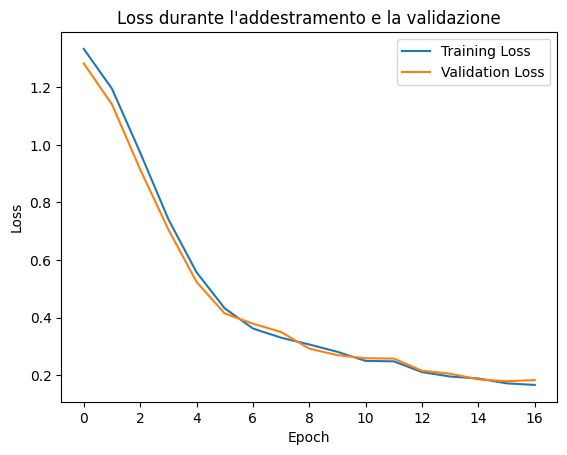

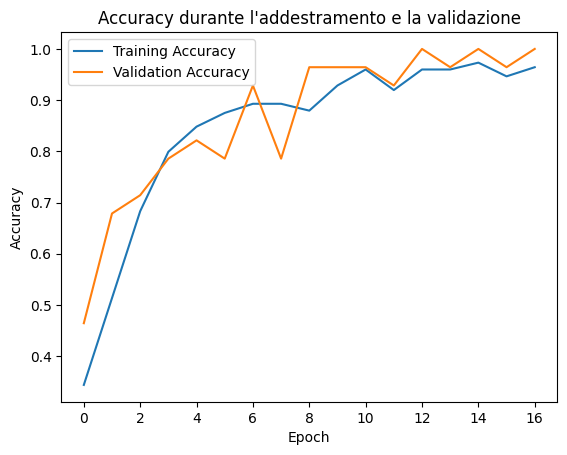

2 42
Epoch 1/17


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 1s 5ms/step - loss: 1.2630 - accuracy: 0.4643 - val_loss: 1.0540 - val_accuracy: 0.7143
Epoch 2/17
75/75 [==============================] - 0s 2ms/step - loss: 1.0011 - accuracy: 0.6652 - val_loss: 0.7999 - val_accuracy: 0.7143
Epoch 3/17
75/75 [==============================] - 0s 2ms/step - loss: 0.7779 - accuracy: 0.7366 - val_loss: 0.6039 - val_accuracy: 0.8929
Epoch 4/17
75/75 [==============================] - 0s 2ms/step - loss: 0.6214 - accuracy: 0.7768 - val_loss: 0.4962 - val_accuracy: 0.8571
Epoch 5/17
75/75 [==============================] - 0s 3ms/step - loss: 0.4942 - accuracy: 0.8527 - val_loss: 0.3919 - val_accuracy: 0.9286
Epoch 6/17
75/75 [==============================] - 0s 2ms/step - loss: 0.4016 - accuracy: 0.8661 - val_loss: 0.3086 - val_accuracy: 0.9643
Epoch 7/17
75/75 [==============================] - 0s 2ms/step - loss: 0.3336 - accuracy: 0.9286 - val_loss: 0.2661 - val_accuracy: 0.8571
Epoch 8/17
75/75 [=============

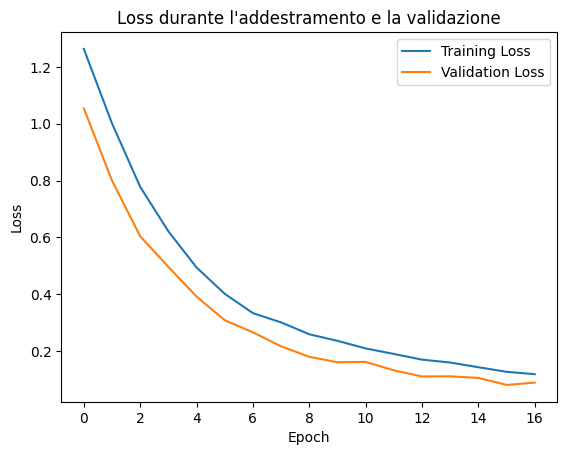

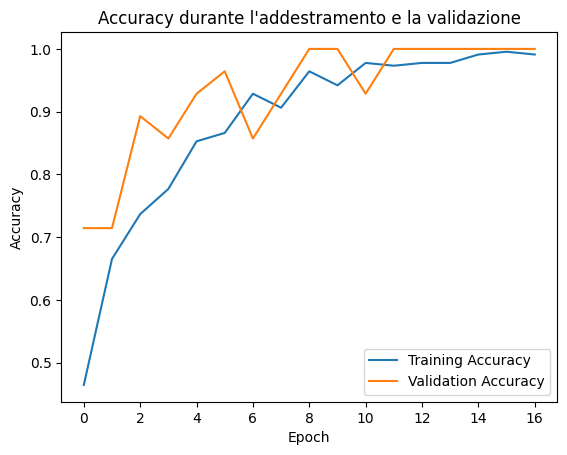

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


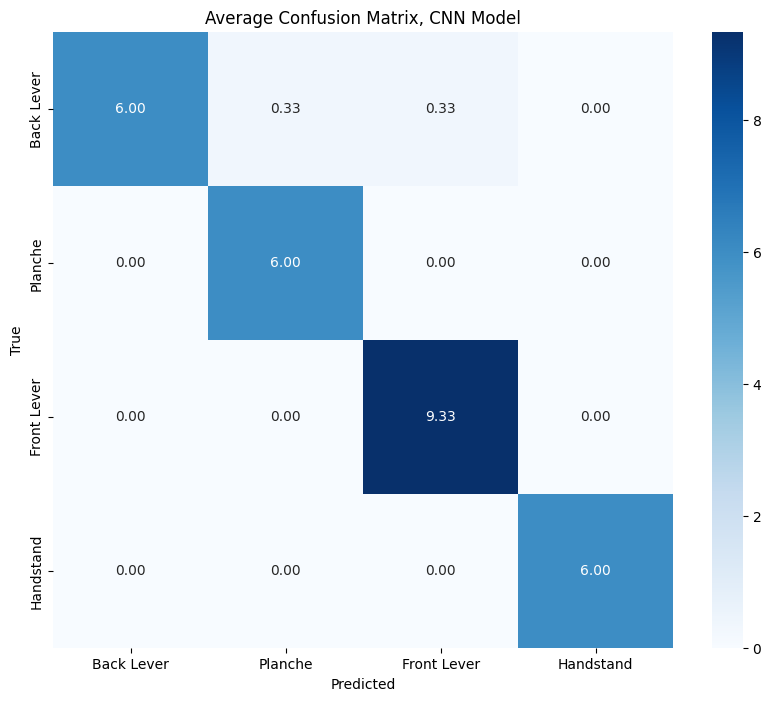

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

runs = [14, 21, 42]
confusion_matrices = []
labels = ['Back Lever', 'Planche', 'Front Lever', 'Handstand']

for i, seed in enumerate(runs):
  print(i, seed)
  y_true, y_pred_classes = split_train_predict(x, y, seed)
  cm = confusion_matrix(y_true, y_pred_classes)
  confusion_matrices.append(cm)

# Calcola la media delle confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Stampa la confusion matrix media
plt.figure(figsize=(10, 8))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Average Confusion Matrix, CNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# from random import randint

# labels = ['back_lever', 'planche', 'front_lever', 'handstand']

# random_index = randint(0, len(x_test) - 1)
# random_sample = x_test[random_index].reshape(1, num_keypoints, num_coordinates, 1)
# print(random_index)

# prediction = model.predict(random_sample)
# predicted_class = np.argmax(prediction)
# print(prediction, predicted_class)

# print(f"True Label: {labels[y_test[random_index]]}, Predicted Label: {labels[predicted_class]}")

27
1/1 [==============================] - 0s 37ms/step
[[7.7878984e-05 9.9984014e-01 8.7528695e-09 8.2003062e-05]] 1
True Label: planche, Predicted Label: planche


## Testing del modello su un dato in input

In [ ]:
from google.colab import files
uploaded = files.upload()
filenames = []

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)

  if len(uploaded.keys()):
    IMAGE_FILE = next(iter(uploaded))
    filenames.append(IMAGE_FILE)
    print('Uploaded file:', IMAGE_FILE)

image = mp.Image.create_from_file(filenames[0])
detection_result = detector.detect(image)
pose_landmarks = detection_result.pose_landmarks[0]

landmarks = []
for i, pl in enumerate(pose_landmarks):
  if( i in significant_indexes):
    coordinates = [pose_landmarks[i].x, pose_landmarks[i].y, pose_landmarks[i].z]
    landmarks.append(coordinates)
landmarks = np.array(landmarks)
landmarks = landmarks.reshape((1, num_keypoints, num_coordinates, 1))

# print(landmarks.shape)
# print(landmarks)

prediction = model.predict(landmarks)
predicted_class = np.argmax(prediction)
print(prediction, predicted_class)

print(f"Predicted Label: {labels[predicted_class]}")


Saving hs_wrong2.jpg to hs_wrong2.jpg
Uploaded file: hs_wrong2.jpg
1/1 [==============================] - 0s 33ms/step
[[4.4808023e-02 1.7916616e-02 2.5287811e-05 9.3725002e-01]] 3
Predicted Label: handstand
